# **Data-Intensive Computing Project**

**By: Kailin Wu and Christian Durán García**

## **Project Description**

**PROBLEM STATEMENT**

Customer churn is a real life problem that is affecting every subscription-like business. In a
world where data is being leveraged in almost every aspect of our lives it is possible to find
patterns and understand in a more profound way why certain people just decide to not
renovate subscriptions for certain services. Finding a way to predict whether a customer will
or will not continue with their subscription may allow businesses to address their strategies
accordingly and take countermeasures against the problem. We are both studying a major in
Engineering in Business Digital Transformation, so, having a set of tools like Spark to
generate predictions suitable for businesses seems like a formidable skill to have our future
involvement in the workforce.

**DATA**

The data we plan to use is in the form of two csv files from Kaggle, located in the next link:
https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset

The data is split into training and test data, and evaluation data. Our intent is to use the
evaluation data for simulating real life cases of customer behavior.

**TOOLS**

- Spark and SparkSQL to pre-process and query the data.
- SparkML to generate machine learning algorithms and make predictions.
- Matplotlib and Seaborn to visualize data for a Exploratory Data Analysis.
- Spark Pandas for easy manipulation of data for EDA.
- Streamlit to present our results in a webapp easy to consume.

**METHODOLOGY**

- Collect and read the data using Spark commands.
- Preprocess data with Spark to generate viable data for analysis.
- Query data with SparkSQL to carry on an Exploratory Data Analysis.
- Generate Spark Pandas DataFrames to use visualization libraries.
- Use training and test data to train a model for churn classification using SparkML.
- Generate predictions with the evaluation data simulating real life cases.
- Visualize the historical and predictive data in an executive webapp.

## **Libraries and Data**

In [2]:
# Spark
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import findspark

# SparkML Models
from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    NaiveBayes,
    LinearSVC,
    MultilayerPerceptronClassifier,
    OneVsRest)

# SparkML Data Pipeline
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Solve problem when importing collections in Python 3.10
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
collections.Callable = collections.abc.Callable

# Data Libraries
import pandas as pd
import databricks.koalas as ks
from collections.abc import Iterable
import matplotlib.pyplot as plt
import seaborn as sns

# Streamlit
import streamlit as st

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Find spark commands
findspark.init()
findspark.find()

c:\Users\cridu.DESKTOP-SDSTA7L\anaconda3\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


'c:\\Users\\cridu.DESKTOP-SDSTA7L\\anaconda3\\lib\\site-packages\\pyspark'

In [3]:
# Create spark session ans visualize the object
spark = SparkSession.builder.appName('Data-Intensive_Project').getOrCreate()

spark

In [4]:
# Read data from csv file
sdf = spark.read.csv('customer_churn_dataset-training-master.csv', header=True, inferSchema=True)

# Show schema
sdf.printSchema()

# Show first 5 rows
sdf.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         2| 30|Female|    39|          

In [6]:
from pyspark.sql.functions import col, count, countDistinct, max

# Describing the whole dataframe
num_cols = [col for col, dtype in sdf.dtypes if dtype in ['int', 'double']]
cat_cols = [col for col, dtype in sdf.dtypes if dtype not in ['int', 'double']]

# Numerical description
num_desc = sdf.select(num_cols).describe()

# Categorical description
cat_desc = sdf.select(cat_cols).agg(
    *[count(col(col_name)).alias(f'count_{col_name}') for col_name in cat_cols],
    *[countDistinct(col(col_name)).alias(f'unique_{col_name}') for col_name in cat_cols],
    *[max(col(col_name)).alias(f'top_{col_name}') for col_name in cat_cols]
)

# Combined description of the dataframe
description = num_desc.crossJoin(cat_desc)

# Show
description.show()

+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------+-----------------------+---------------------+-------------+------------------------+----------------------+----------+---------------------+-------------------+
|summary|        CustomerID|               Age|           Tenure|  Usage Frequency|     Support Calls|     Payment Delay|      Total Spend|  Last Interaction|              Churn|count_Gender|count_Subscription Type|count_Contract Length|unique_Gender|unique_Subscription Type|unique_Contract Length|top_Gender|top_Subscription Type|top_Contract Length|
+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------+-----------------------+---------------------+-------------+------------------------+------------------

## **Data Cleaning**

In [7]:
# Important libraries to perform the following task
from pyspark.sql.functions import isnan, when

# Calculate the number of null values for each column
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         1|  1|     1|     1|              1|            1|            1|                1|              1|          1|               1|    1|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



In [8]:
# Defining a function that will help to print out all the rows with null values independently of the column
def get_null_rows(sdf):
    # Condition
    conditions = [col(column).isNull() for column in sdf.columns]
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition = combined_condition | condition

    # Filter df for rows that meet the condition
    null_rows = sdf.filter(combined_condition)

    # Print the number of rows
    print('Number of rows with at least one null value:', null_rows.count())

    # Return rows with null values
    return null_rows

# Display the null rows
get_null_rows(sdf).show()

Number of rows with at least one null value: 1
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID| Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|      null|null|  null|  null|           null|         null|         null|             null|           null|       null|            null| null|
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



As it can be seen from the output of the previous cell, there is only one null row that has at least one null value. This row has null values for all the columns in the dataset, so, as it is for now, the best way to handle the null values is to simply drop them.

In [9]:
# Dropping null row
sdf = sdf.na.drop()

#  Checking if the operation is successful
get_null_rows(sdf).show()

Number of rows with at least one null value: 0
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



Now that the dataset is fairly clean and does not contain any type of values that may hinder any further analysis, we can procceed to realize the Exploratory Data Analysis.

## **EDA (Exploratory Data Analysis)**

**OVERALL DESCRIPTION FOR THE EXPLORATORY DATA ANALYSIS**

The analysis will be divided in to two main categories:
- Numerical Columns
- Categorical Columns

For each of these categories, some global analysis will be performed, then particular analysis to each variable.

For each relevant numerical variable:
- Descriptive statistics
- Correlations
- Distribution
- Related vriables

For each relevant categorical variable:
- Counts
- Unique values
- Related variables
- Creation of categories

### _Numerical Variables_

In [21]:
# Getting a dataframe only with numerical columns
num_cols = [column[0] for column in sdf.dtypes if column[1] in ['int', 'double'] and column[0] != 'CustomerID']

num_sdf = sdf.select(num_cols)

num_sdf.printSchema()

num_sdf.describe().show()

root
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

+-------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+
|summary|               Age|           Tenure|  Usage Frequency|     Support Calls|     Payment Delay|      Total Spend|  Last Interaction|              Churn|
+-------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+
|  count|            440832|           440832|           440832|            440832|            440832|           440832|            440832|             440832|
|   mean|

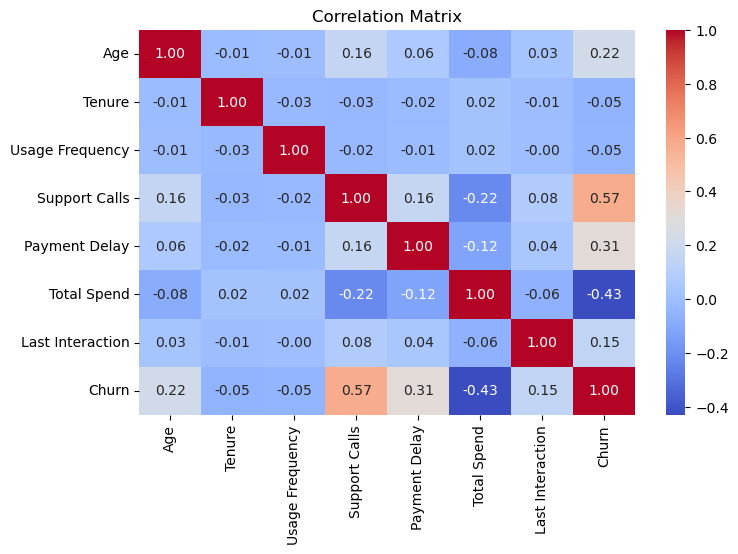

In [11]:
# Function to perform the correlation matrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Creating the vector assembler with the selected columns
vec_assembler = VectorAssembler(inputCols=num_cols, outputCol='features')

# Transform the data into the desired features
num_sdf_transformed = vec_assembler.transform(num_sdf)

# Calculate the correlation matrix
correlations = Correlation.corr(num_sdf_transformed, 'features').collect()[0][0]

# Convert the PySpark dense matrix to a Python List
corr_matrix = correlations.toArray().tolist()

# Create a Pandas DataFrame from the list
corr_matrix_df = pd.DataFrame(corr_matrix, columns=num_cols, index=num_cols)

# Visualize the correlation matrix using seaborn and matplotlib
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

From this starting point it seems that most of the numerical variables seem to not be related at all in a linear way.

Two correlations that might be worth looking into are the Churn / Support Cals and Churn / Total Spend.

- Churn / Support Calls has a positive correlation stronger than 0.50, it's not much but with some interpretation we can conclude that seems plausible that a customer is more likely to churn if they need a lot of support from client service.
- Churn / Total Spend has a negative correlation weaker than 0.40, it's not much as well but there can be some connection between users that do not spend much in their subscription and churning.

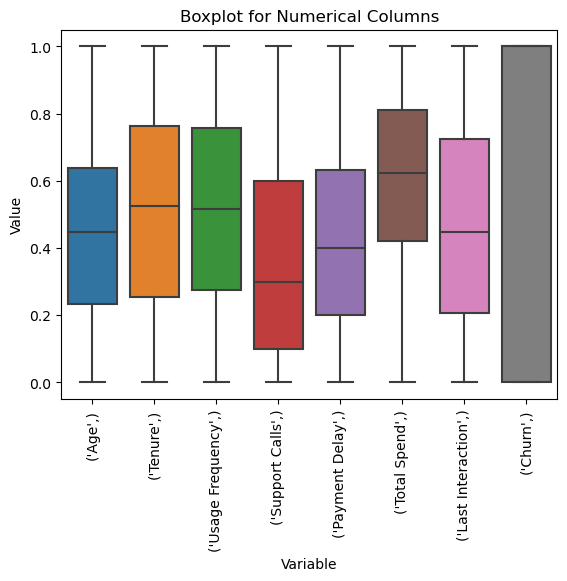

In [50]:
# Visualizing the numerical features in a boxplot, need to use a MinMaxScaler
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

vect = VectorAssembler(inputCols=num_cols, outputCol='features')
vect_num_sdf = vect.transform(num_sdf)

scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
scaled_model = scaler.fit(vect_num_sdf)
scaled_sdf = scaled_model.transform(vect_num_sdf)

scaled_data = scaled_sdf.select('scaled_features').toPandas()

data_for_plot = pd.DataFrame(scaled_data['scaled_features'].tolist(), columns=[num_cols])

sns.boxplot(data_for_plot);
plt.xticks(rotation=90)
plt.title('Boxplot for Numerical Columns')
plt.ylabel('Value')
plt.xlabel('Variable')
plt.show()

#### Age

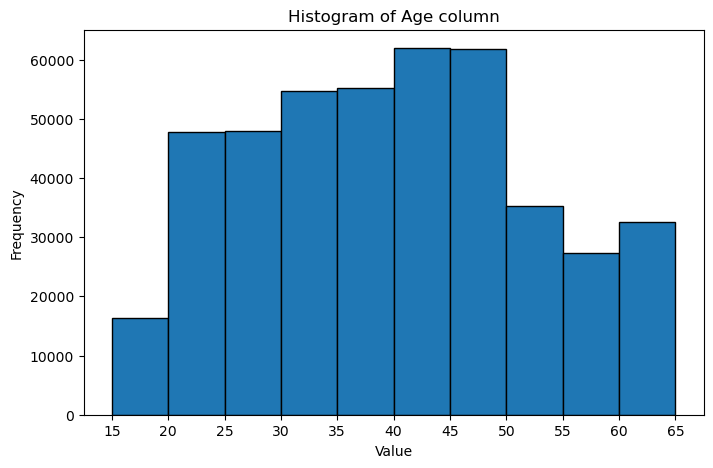

In [51]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Age').toPandas(), bins=range(15,70,5), edgecolor='black')
plt.xticks(range(15,70,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Age column")
plt.show()

#### Tenure

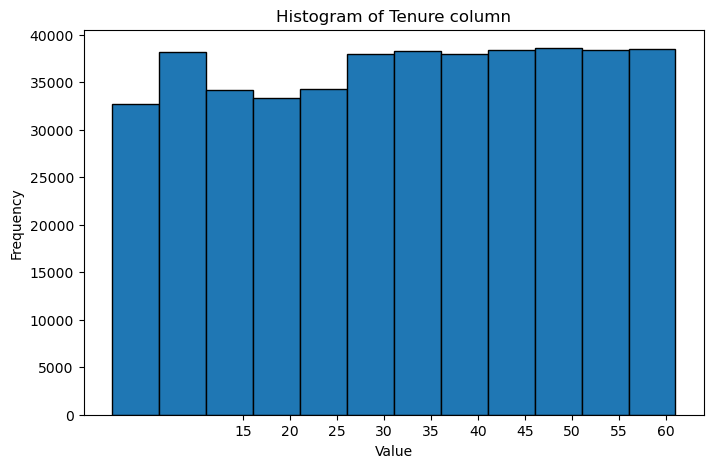

In [54]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Tenure').toPandas(), bins=range(1,65,5), edgecolor='black')
plt.xticks(range(15,65,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Tenure column")
plt.show()

#### Usage Frequency

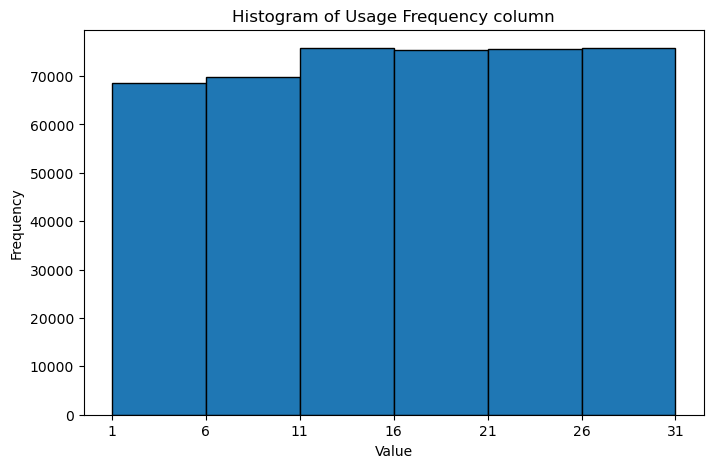

In [56]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Usage Frequency').toPandas(), bins=range(1,35,5), edgecolor='black')
plt.xticks(range(1,35,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Usage Frequency column")
plt.show()

#### Support Calls

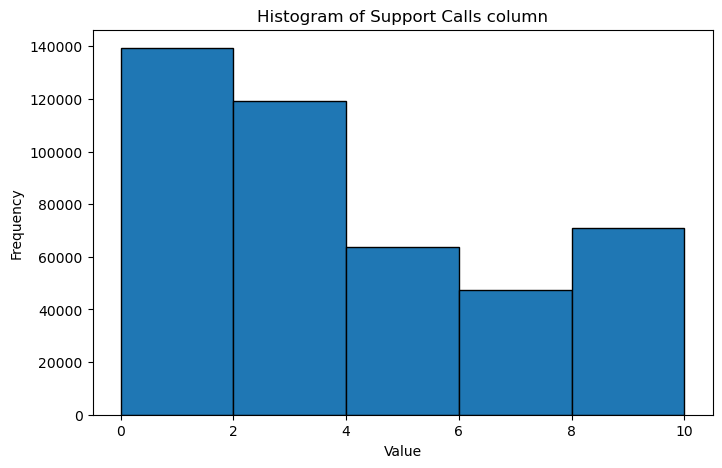

In [59]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Support Calls').toPandas(), bins=range(0,11,2), edgecolor='black')
plt.xticks(range(0,11,2))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Support Calls column")
plt.show()

#### Payment Delay

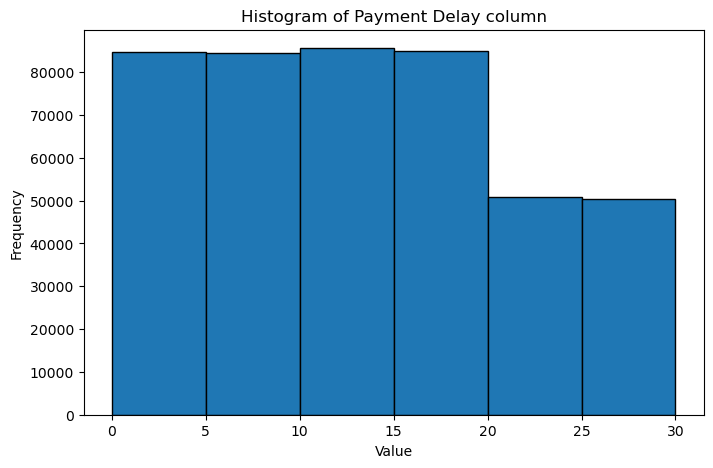

In [60]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Payment Delay').toPandas(), bins=range(0,35,5), edgecolor='black')
plt.xticks(range(0,35,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Payment Delay column")
plt.show()

#### Total Spent

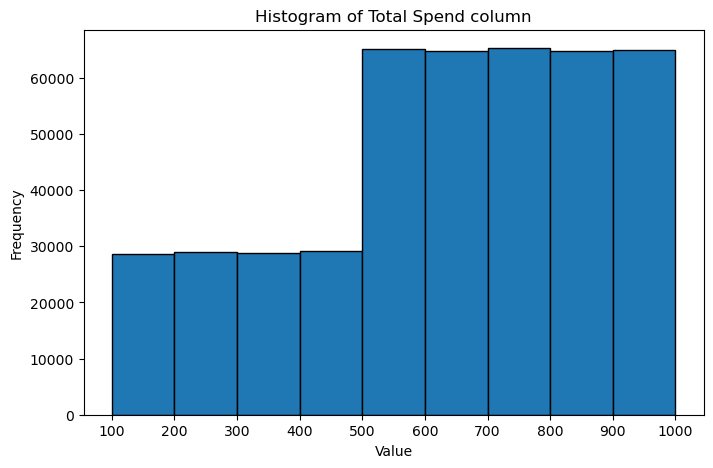

In [61]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Total Spend').toPandas(), bins=range(100,1001,100), edgecolor='black')
plt.xticks(range(100,1001,100))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Total Spend column")
plt.show()

#### Last Interaction

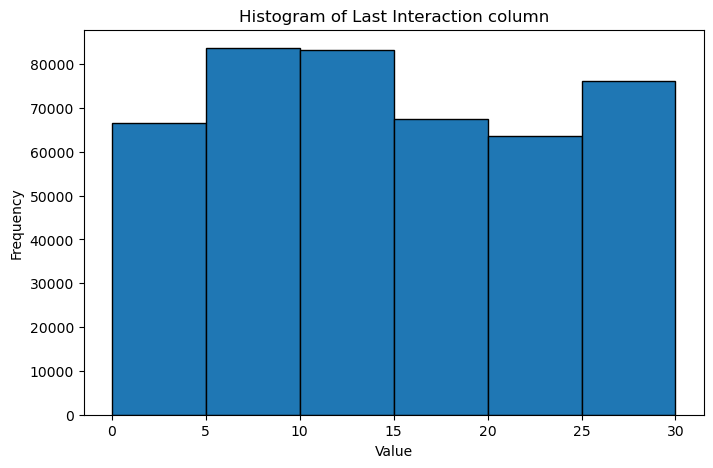

In [62]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Last Interaction').toPandas(), bins=range(0,31,5), edgecolor='black')
plt.xticks(range(0,31,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Last Interaction column")
plt.show()

### _Categorical Variables_

In [27]:
# Getting a dataframe only with categorical columns
cat_cols = [column[0] for column in sdf.dtypes if column[1] not in ['int', 'double']]

cat_sdf = sdf.select(cat_cols)

cat_sdf.printSchema()

cat_sdf.show(5)

root
 |-- Gender: string (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)

+------+-----------------+---------------+
|Gender|Subscription Type|Contract Length|
+------+-----------------+---------------+
|Female|         Standard|         Annual|
|Female|            Basic|        Monthly|
|Female|            Basic|      Quarterly|
|  Male|         Standard|        Monthly|
|  Male|            Basic|        Monthly|
+------+-----------------+---------------+
only showing top 5 rows



#### Gender

#### Subscription Type

#### Contract Length

### EDA Conclusions

## **Modeling**